# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Philipp Spiess"
student2 = "Thomas Avon"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [19]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras import regularizers
from keras.regularizers import l1, l2
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam

### Plotting

In [20]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

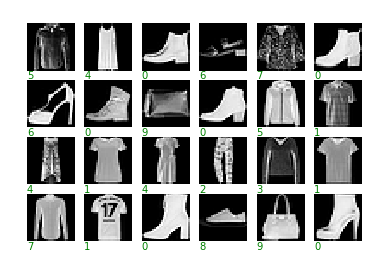

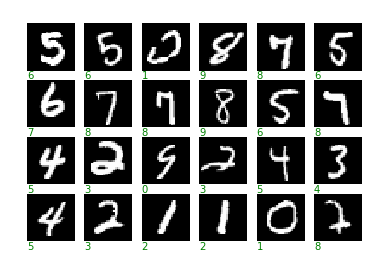

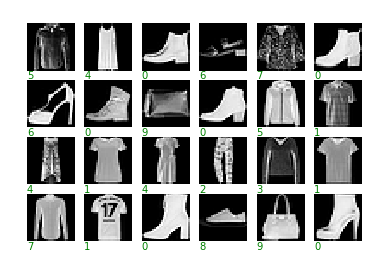

In [21]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

y_test_label = y_test
yf_test_label = y_fashion_test

plot_some_samples(x_test, y_test)
plot_some_samples(x_fashion_test, y_fashion_test)

Answer to question 2: The green digits represent the true label of each picture.

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [21]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [22]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [ ]:
def make_basic_model(nb_class, nb_hidden_layer, x_train, y_train, x_test, y_test, epochs):
    model.add(Dense(nb_class, activation='softmax'))
    model.compile(optimizer='sgd',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=128)
    return history

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 1s 18us/step - loss: 1.2830 - acc: 0.6955 - val_loss: 0.8103 - val_acc: 0.8333
Epoch 2/200
60000/60000 [==============================] - 1s 11us/step - loss: 0.7150 - acc: 0.8390 - val_loss: 0.6060 - val_acc: 0.8612
Epoch 3/200
60000/60000 [==============================] - 1s 11us/step - loss: 0.5859 - acc: 0.8586 - val_loss: 0.5246 - val_acc: 0.8766
Epoch 4/200
60000/60000 [==============================] - 1s 11us/step - loss: 0.5241 - acc: 0.8687 - val_loss: 0.4788 - val_acc: 0.8826
Epoch 5/200
60000/60000 [==============================] - 1s 11us/step - loss: 0.4865 - acc: 0.8753 - val_loss: 0.4497 - val_acc: 0.8863
Epoch 6/200
60000/60000 [==============================] - 1s 12us/step - loss: 0.4608 - acc: 0.8800 - val_loss: 0.4282 - val_acc: 0.8893
Epoch 7/200
60000/60000 [==============================] - 1s 12us/step - loss: 0.4417 - acc: 0.8837 - val_loss: 0.4122 - 

Epoch 118/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.2823 - acc: 0.9213 - val_loss: 0.2800 - val_acc: 0.9214
Epoch 119/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.2821 - acc: 0.9215 - val_loss: 0.2795 - val_acc: 0.9216
Epoch 120/200
60000/60000 [==============================] - 1s 11us/step - loss: 0.2818 - acc: 0.9215 - val_loss: 0.2796 - val_acc: 0.9216
Epoch 121/200
60000/60000 [==============================] - 1s 11us/step - loss: 0.2816 - acc: 0.9219 - val_loss: 0.2795 - val_acc: 0.9221
Epoch 122/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.2814 - acc: 0.9216 - val_loss: 0.2793 - val_acc: 0.9218
Epoch 123/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.2812 - acc: 0.9219 - val_loss: 0.2793 - val_acc: 0.9222
Epoch 124/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.2810 - acc: 0.9221 - val_loss: 0.2788 - val_acc: 0.9219
Epoch 125/200
60000/

60000/60000 [==============================] - 1s 11us/step - loss: 0.4594 - acc: 0.8461 - val_loss: 0.4908 - val_acc: 0.8313
Epoch 35/200
60000/60000 [==============================] - 1s 11us/step - loss: 0.4579 - acc: 0.8466 - val_loss: 0.4888 - val_acc: 0.8321
Epoch 36/200
60000/60000 [==============================] - 1s 11us/step - loss: 0.4565 - acc: 0.8461 - val_loss: 0.4880 - val_acc: 0.8334
Epoch 37/200
60000/60000 [==============================] - 1s 11us/step - loss: 0.4551 - acc: 0.8470 - val_loss: 0.4885 - val_acc: 0.8302
Epoch 38/200
60000/60000 [==============================] - 1s 11us/step - loss: 0.4537 - acc: 0.8478 - val_loss: 0.4855 - val_acc: 0.8331
Epoch 39/200
60000/60000 [==============================] - 1s 12us/step - loss: 0.4526 - acc: 0.8476 - val_loss: 0.4848 - val_acc: 0.8337
Epoch 40/200
60000/60000 [==============================] - 1s 12us/step - loss: 0.4515 - acc: 0.8479 - val_loss: 0.4834 - val_acc: 0.8328
Epoch 41/200
60000/60000 [==============

60000/60000 [==============================] - 1s 11us/step - loss: 0.4177 - acc: 0.8585 - val_loss: 0.4568 - val_acc: 0.8398
Epoch 94/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.4175 - acc: 0.8578 - val_loss: 0.4571 - val_acc: 0.8392
Epoch 95/200
60000/60000 [==============================] - 1s 11us/step - loss: 0.4170 - acc: 0.8583 - val_loss: 0.4562 - val_acc: 0.8400
Epoch 96/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.4168 - acc: 0.8591 - val_loss: 0.4561 - val_acc: 0.8398
Epoch 97/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.4163 - acc: 0.8589 - val_loss: 0.4556 - val_acc: 0.8403
Epoch 98/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.4160 - acc: 0.8587 - val_loss: 0.4557 - val_acc: 0.8394
Epoch 99/200
60000/60000 [==============================] - 1s 10us/step - loss: 0.4157 - acc: 0.8587 - val_loss: 0.4566 - val_acc: 0.8364
Epoch 100/200
60000/60000 [=============

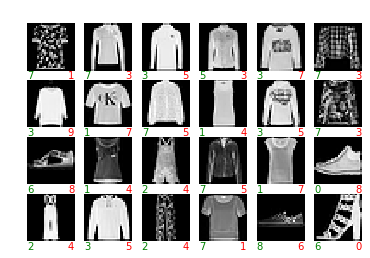

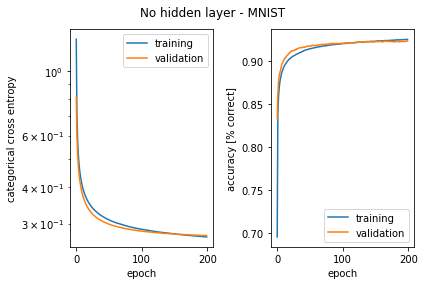

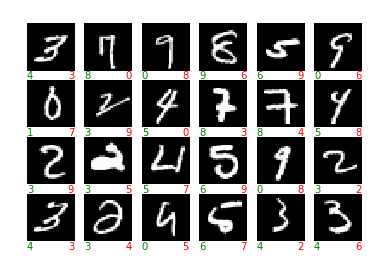

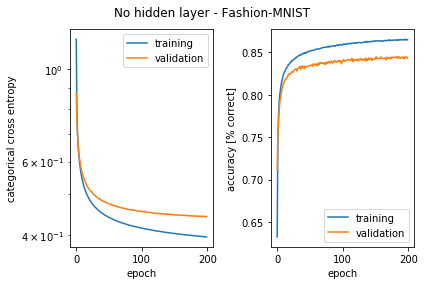

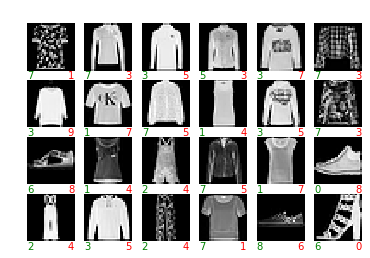

In [17]:
model = Sequential()
history = make_basic_model(10, 0, x_train, y_train, x_test, y_test, 200)
plot_history(history, 'No hidden layer - MNIST')

yhat_test = model.predict_classes(x_test)
error_indices = np.nonzero(yhat_test != y_test_label)
plot_some_samples(x_test, y_test, yhat_test, error_indices[0])

model = Sequential()
history = make_basic_model(10, 0, x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 200)
plot_history(history, 'No hidden layer - Fashion-MNIST')

yhat_fashion_test = model.predict_classes(x_fashion_test)
error_indices = np.nonzero(yhat_fashion_test != yf_test_label)
plot_some_samples(x_fashion_test, y_fashion_test, yhat_fashion_test, error_indices[0])

Answer to question 10: The green digit represents the true label of the picture. There is a -1 shift so for example 5 is labeled by the digit 4. The red digit represents the wrongly predicted label.

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [9]:
def make_model(nb_class, nb_hidden_layer, x_train, y_train, x_test, y_test, epochs, lr, opt, nb_hidden_neuron, tuned=0):
    model = Sequential()
    if opt == 'sgd':
        sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
        opt = sgd
    for i in range(nb_hidden_layer):
        if tuned == 1 :
            keras.regularizers.l1(0.)
            keras.regularizers.l2(0.)
            keras.regularizers.l1_l2(l1=0.01, l2=0.01)
            model.add(Dropout(0.2))
            model.add(BatchNormalization()) 
        model.add(Dense(nb_hidden_neuron, activation='relu'))
    model.add(Dense(nb_class, activation='softmax'))
    model.compile(optimizer=opt,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=128)
    model.summary()
    return history

In [19]:
#different learning rates tried:
history_sgd= make_model(10, 1, x_train, y_train, x_test, y_test, 50, 0.1, 'sgd',128)
history_sgd_bis= make_model(10, 1, x_train, y_train, x_test, y_test, 50, 0.01, 'sgd',128)

history_adam = make_model(10, 1, x_train, y_train, x_test, y_test, 50,0, 'adam',128)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2461 - acc: 0.9272 - val_loss: 0.1230 - val_acc: 0.9609
Epoch 2/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.1038 - acc: 0.9691 - val_loss: 0.0936 - val_acc: 0.9697
Epoch 3/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0728 - acc: 0.9776 - val_loss: 0.0942 - val_acc: 0.9715
Epoch 4/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.0548 - acc: 0.9829 - val_loss: 0.0846 - val_acc: 0.9730
Epoch 5/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.0434 - acc: 0.9864 - val_loss: 0.0751 - val_acc: 0.9765
Epoch 6/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.0335 - acc: 0.9897 - val_loss: 0.0785 - val_acc: 0.9782
Epoch 7/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0263 - acc: 0.9920 - val_loss: 0.0800 - val_acc

Epoch 5/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.1594 - acc: 0.9559 - val_loss: 0.1497 - val_acc: 0.9574
Epoch 6/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.1409 - acc: 0.9611 - val_loss: 0.1384 - val_acc: 0.9602
Epoch 7/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.1258 - acc: 0.9647 - val_loss: 0.1253 - val_acc: 0.9642
Epoch 8/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.1142 - acc: 0.9683 - val_loss: 0.1205 - val_acc: 0.9665
Epoch 9/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.1042 - acc: 0.9711 - val_loss: 0.1127 - val_acc: 0.9677
Epoch 10/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.0956 - acc: 0.9741 - val_loss: 0.1053 - val_acc: 0.9700
Epoch 11/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.0887 - acc: 0.9759 - val_loss: 0.1002 - val_acc: 0.9700
Epoch 12/50
60000/60000 [==============

Epoch 10/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0309 - acc: 0.9913 - val_loss: 0.0685 - val_acc: 0.9797
Epoch 11/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0265 - acc: 0.9932 - val_loss: 0.0714 - val_acc: 0.9782
Epoch 12/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0220 - acc: 0.9945 - val_loss: 0.0740 - val_acc: 0.9782
Epoch 13/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0188 - acc: 0.9952 - val_loss: 0.0712 - val_acc: 0.9786
Epoch 14/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.0159 - acc: 0.9961 - val_loss: 0.0702 - val_acc: 0.9792
Epoch 15/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0135 - acc: 0.9973 - val_loss: 0.0745 - val_acc: 0.9778
Epoch 16/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0105 - acc: 0.9982 - val_loss: 0.0747 - val_acc: 0.9782
Epoch 17/50
60000/60000 [=========

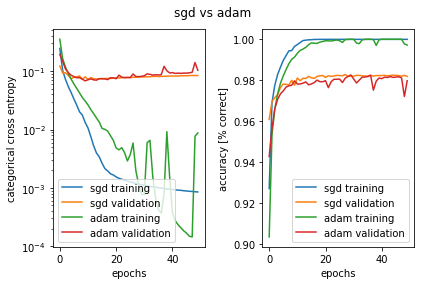

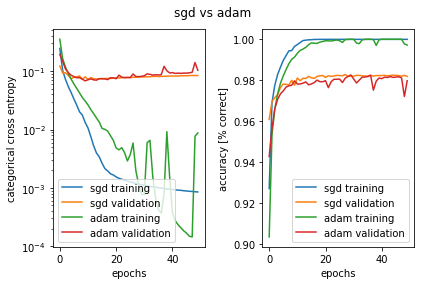

In [20]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

comparison_plot(history_sgd, history_adam, 'sgd', 'adam', 'sgd vs adam')

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) Both the validation error and accuracy are unstable and 'noisy'. The values often get very far from the desired ones.

B) The improvement is very slow as the number of epochs rises. A far higher number of epochs would be needed.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: At, approximately, 15 epochs, the cross entropy rises, that is the optimizer starts to overfit.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: The concept of overfitting takes place in some cases where our model starts to fit the noise of the training data.
Thus we can see overfitting when the training accuracy increases however the validation accuracy stays the same or even degrades. In our experiment, we observe the increase in validation loss but a decrease in training loss after the model starts to overfit (around epoch 15).

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.5640 - acc: 0.8055 - val_loss: 0.4623 - val_acc: 0.8366
Epoch 2/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.4070 - acc: 0.8565 - val_loss: 0.4195 - val_acc: 0.8506
Epoch 3/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.3652 - acc: 0.8701 - val_loss: 0.3812 - val_acc: 0.8629
Epoch 4/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.3435 - acc: 0.8762 - val_loss: 0.3925 - val_acc: 0.8599
Epoch 5/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.3206 - acc: 0.8833 - val_loss: 0.3698 - val_acc: 0.8648
Epoch 6/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.3061 - acc: 0.8893 - val_loss: 0.3707 - val_acc: 0.8670
Epoch 7/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.2942 - acc: 0.8924 - val_loss: 0.3636 - val_acc

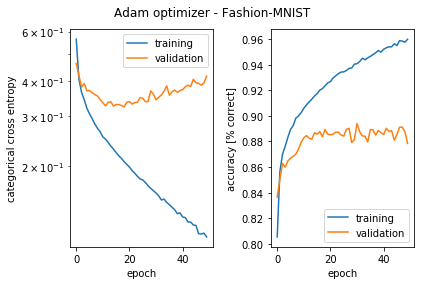

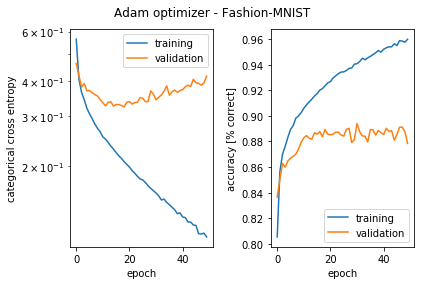

In [21]:
history_adam_fashion = make_model(10, 1, x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 50,0, 'adam',128)
plot_history(history_adam_fashion, 'Adam optimizer - Fashion-MNIST')

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [10]:
history_adam10 = make_model(10, 1, x_train, y_train, x_test, y_test, 30,0, 'adam',10)
history_adam30 = make_model(10, 1, x_train, y_train, x_test, y_test, 30,0, 'adam',100)
history_adam100 = make_model(10, 1, x_train, y_train, x_test, y_test, 30,0, 'adam',300)
history_adam300 = make_model(10, 1, x_train, y_train, x_test, y_test, 30,0, 'adam',600)
history_adam1000 = make_model(10, 1, x_train, y_train, x_test, y_test, 30,0, 'adam',1000)

y_loss = [max(history_adam10.history['val_loss']),max(history_adam30.history['val_loss']),
     max(history_adam100.history['val_loss']),max(history_adam300.history['val_loss']),
     max(history_adam1000.history['val_loss'])]
y_acc = [max(history_adam10.history['val_acc']),max(history_adam30.history['val_acc']),
     max(history_adam100.history['val_acc']),max(history_adam300.history['val_acc']),
     max(history_adam1000.history['val_acc'])]


history_adam_f10 = make_model(10, 1, x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 30,0, 'adam',10)
history_adam_f30 = make_model(10, 1, x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 30,0, 'adam',100)
history_adam_f100 = make_model(10, 1, x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 30,0, 'adam',300)
history_adam_f300 = make_model(10, 1, x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 30,0, 'adam',600)
history_adam_f1000 = make_model(10, 1, x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 30,0, 'adam',1000)


y_loss_f = [max(history_adam_f10.history['val_loss']),max(history_adam_f30.history['val_loss']),
     max(history_adam_f100.history['val_loss']),max(history_adam_f300.history['val_loss']),
     max(history_adam_f1000.history['val_loss'])]
y_acc_f = [max(history_adam_f10.history['val_acc']),max(history_adam_f30.history['val_acc']),
     max(history_adam_f100.history['val_acc']),max(history_adam_f300.history['val_acc']),
     max(history_adam_f1000.history['val_acc'])]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 1s 16us/step - loss: 0.8070 - acc: 0.7719 - val_loss: 0.3706 - val_acc: 0.8942
Epoch 2/30
60000/60000 [==============================] - 1s 13us/step - loss: 0.3493 - acc: 0.9013 - val_loss: 0.3098 - val_acc: 0.9089
Epoch 3/30
60000/60000 [==============================] - 1s 13us/step - loss: 0.3048 - acc: 0.9137 - val_loss: 0.2816 - val_acc: 0.9161
Epoch 4/30
60000/60000 [==============================] - 1s 14us/step - loss: 0.2825 - acc: 0.9199 - val_loss: 0.2653 - val_acc: 0.9206
Epoch 5/30
60000/60000 [==============================] - 1s 13us/step - loss: 0.2663 - acc: 0.9244 - val_loss: 0.2573 - val_acc: 0.9251
Epoch 6/30
60000/60000 [==============================] - 1s 14us/step - loss: 0.2550 - acc: 0.9279 - val_loss: 0.2492 - val_acc: 0.9273
Epoch 7/

60000/60000 [==============================] - 2s 39us/step - loss: 0.0058 - acc: 0.9989 - val_loss: 0.0659 - val_acc: 0.9825
Epoch 12/30
60000/60000 [==============================] - 2s 40us/step - loss: 0.0055 - acc: 0.9987 - val_loss: 0.0699 - val_acc: 0.9807
Epoch 13/30
60000/60000 [==============================] - 3s 43us/step - loss: 0.0060 - acc: 0.9983 - val_loss: 0.0711 - val_acc: 0.9813
Epoch 14/30
60000/60000 [==============================] - 3s 43us/step - loss: 0.0092 - acc: 0.9971 - val_loss: 0.0999 - val_acc: 0.9749
Epoch 15/30
60000/60000 [==============================] - 3s 43us/step - loss: 0.0058 - acc: 0.9984 - val_loss: 0.0797 - val_acc: 0.9797
Epoch 16/30
60000/60000 [==============================] - 2s 39us/step - loss: 0.0055 - acc: 0.9985 - val_loss: 0.0873 - val_acc: 0.9780
Epoch 17/30
60000/60000 [==============================] - 2s 39us/step - loss: 0.0042 - acc: 0.9990 - val_loss: 0.0688 - val_acc: 0.9830
Epoch 18/30
60000/60000 [=====================

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 1s 19us/step - loss: 0.7783 - acc: 0.7393 - val_loss: 0.5718 - val_acc: 0.8071
Epoch 2/30
60000/60000 [==============================] - 1s 12us/step - loss: 0.5169 - acc: 0.8258 - val_loss: 0.5200 - val_acc: 0.8219
Epoch 3/30
60000/60000 [==============================] - 1s 12us/step - loss: 0.4733 - acc: 0.8385 - val_loss: 0.4951 - val_acc: 0.8277
Epoch 4/30
60000/60000 [==============================] - 1s 12us/step - loss: 0.4527 - acc: 0.8458 - val_loss: 0.4862 - val_acc: 0.8295
Epoch 5/30
60000/60000 [==============================] - 1s 12us/step - loss: 0.4393 - acc: 0.8475 - val_loss: 0.4779 - val_acc: 0.8328
Epoch 6/30
60000/60000 [==============================] - 1s 12us/step - loss: 0.4300 - acc: 0.8517 - val_loss: 0.4672 - val_acc: 0.8349
Epoch 7/30
60000/60000 [==============================] - 1s 12us/step - loss: 0.4213 - acc: 0.8560 - val_loss: 0.4641 - val_acc

60000/60000 [==============================] - 2s 38us/step - loss: 0.1879 - acc: 0.9295 - val_loss: 0.3375 - val_acc: 0.8833
Epoch 16/30
60000/60000 [==============================] - 3s 42us/step - loss: 0.1797 - acc: 0.9326 - val_loss: 0.3132 - val_acc: 0.8943
Epoch 17/30
60000/60000 [==============================] - 2s 39us/step - loss: 0.1731 - acc: 0.9361 - val_loss: 0.3236 - val_acc: 0.8932
Epoch 18/30
60000/60000 [==============================] - 2s 40us/step - loss: 0.1682 - acc: 0.9380 - val_loss: 0.3242 - val_acc: 0.8928
Epoch 19/30
60000/60000 [==============================] - 2s 38us/step - loss: 0.1638 - acc: 0.9392 - val_loss: 0.3229 - val_acc: 0.8947
Epoch 20/30
60000/60000 [==============================] - 2s 39us/step - loss: 0.1565 - acc: 0.9420 - val_loss: 0.3411 - val_acc: 0.8919
Epoch 21/30
60000/60000 [==============================] - 2s 40us/step - loss: 0.1531 - acc: 0.9418 - val_loss: 0.3298 - val_acc: 0.8940
Epoch 22/30
60000/60000 [=====================

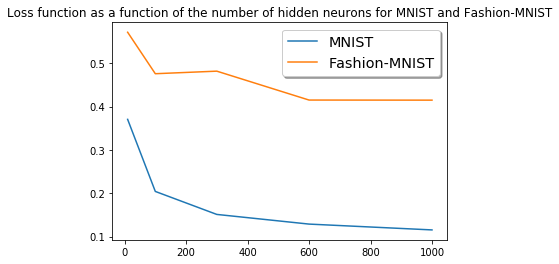

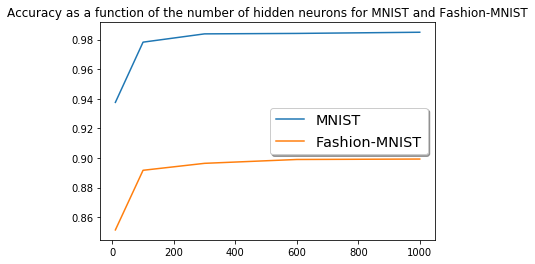

In [17]:
x = [10,100,300,600,1000]
fig, ax = plt.subplots()
plt.title('Loss function as a function of the number of hidden neurons for MNIST and Fashion-MNIST')
ax.plot(x,y_loss, label="MNIST")
ax.plot(x,y_loss_f, label="Fashion-MNIST")
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
fig, ax = plt.subplots()
plt.title('Accuracy as a function of the number of hidden neurons for MNIST and Fashion-MNIST')
ax.plot(x,y_acc, label="MNIST")         
ax.plot(x,y_acc_f, label="Fashion-MNIST")
legend = ax.legend(loc='center right', shadow=True, fontsize='x-large')

Answer to question 2: Yes, the trend is in accordance with the theorem: more neurons in a single layer will in fact increase the accuracy of the classifier.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 45us/step - loss: 0.6089 - acc: 0.7897 - val_loss: 0.4508 - val_acc: 0.8457
Epoch 2/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.4134 - acc: 0.8532 - val_loss: 0.4135 - val_acc: 0.8537
Epoch 3/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3730 - acc: 0.8656 - val_loss: 0.4022 - val_acc: 0.8533
Epoch 4/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3452 - acc: 0.8752 - val_loss: 0.3970 - val_acc: 0.8613
Epoch 5/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3312 - acc: 0.8791 - val_loss: 0.3686 - val_acc: 0.8701
Epoch 6/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.3135 - acc: 0.8851 - val_loss: 0.3595 - val_acc: 0.8708
Epoch 7/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.3028 - acc: 0.8882 - val_loss: 0.3595 - 

Epoch 9/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.4121 - acc: 0.8480 - val_loss: 0.3667 - val_acc: 0.8643
Epoch 10/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.4115 - acc: 0.8476 - val_loss: 0.3607 - val_acc: 0.8706
Epoch 11/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.4069 - acc: 0.8511 - val_loss: 0.3597 - val_acc: 0.8691
Epoch 12/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.4018 - acc: 0.8534 - val_loss: 0.3629 - val_acc: 0.8701
Epoch 13/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.3963 - acc: 0.8538 - val_loss: 0.3555 - val_acc: 0.8689
Epoch 14/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.3940 - acc: 0.8538 - val_loss: 0.3513 - val_acc: 0.8739
Epoch 15/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.3865 - acc: 0.8560 - val_loss: 0.3466 - val_acc: 0.8725
Epoch 16/100
60000/60000 [==

Epoch 68/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.3437 - acc: 0.8718 - val_loss: 0.3296 - val_acc: 0.8792
Epoch 69/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.3491 - acc: 0.8725 - val_loss: 0.3290 - val_acc: 0.8798
Epoch 70/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.3505 - acc: 0.8698 - val_loss: 0.3277 - val_acc: 0.8785
Epoch 71/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.3487 - acc: 0.8701 - val_loss: 0.3311 - val_acc: 0.8783
Epoch 72/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.3454 - acc: 0.8728 - val_loss: 0.3277 - val_acc: 0.8804
Epoch 73/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.3460 - acc: 0.8727 - val_loss: 0.3289 - val_acc: 0.8834
Epoch 74/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.3486 - acc: 0.8713 - val_loss: 0.3288 - val_acc: 0.8795
Epoch 75/100
60000/60000 [=

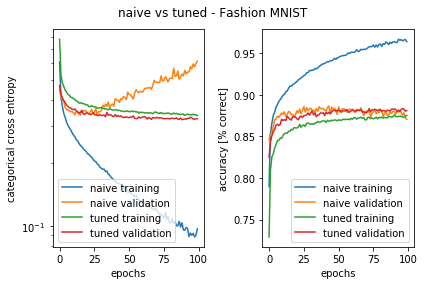

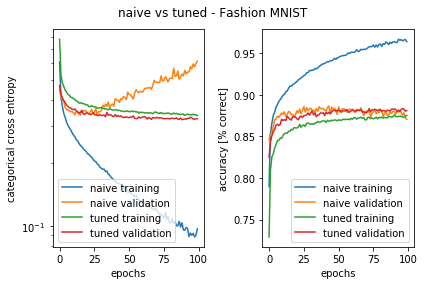

In [26]:
history_adam_fashion_naive = make_model(10, 3, x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 100,0, 'adam',50, 0)
history_adam_fashion_tuned = make_model(10, 3, x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 100,0, 'adam',50, 1)
comparison_plot(history_adam_fashion_naive, history_adam_fashion_tuned, 'naive', 'tuned', 'naive vs tuned - Fashion MNIST')



Answer to question 2 (comments): Compare to only 1 hidden layer, both the accuracy and the loss function are better with 3 layers, but we see on the accuracy plot that the tuned model only gets better than the naive model after a big amount of epochs (about 90 in this case).

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 74us/step - loss: 0.6855 - acc: 0.7866 - val_loss: 0.2427 - val_acc: 0.9274
Epoch 2/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.3497 - acc: 0.8931 - val_loss: 0.1817 - val_acc: 0.9436
Epoch 3/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.2969 - acc: 0.9086 - val_loss: 0.1619 - val_acc: 0.9512
Epoch 4/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.2650 - acc: 0.9178 - val_loss: 0.1501 - val_acc: 0.9561
Epoch 5/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.2411 - acc: 0.9268 - val_loss: 0.1424 - val_acc: 0.9575
Epoch 6/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.2268 - acc: 0.9294 - val_loss: 0.1292 - val_acc: 0.9609
Epoch 7/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.2155 - acc: 0.9339 - val_loss: 0.1279 - 

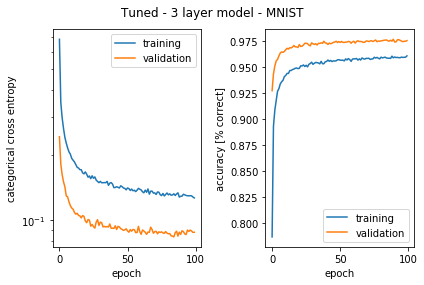

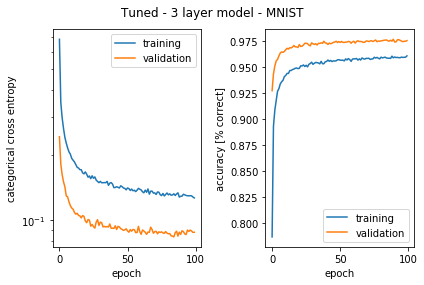

In [27]:
history_adam_tuned = make_model(10, 3, x_train, y_train, x_test, y_test, 100,0, 'adam', 50, 1)
plot_history(history_adam_tuned, 'Tuned - 3 layer model - MNIST')




## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [22]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_fashion_train = x_fashion_train.reshape(x_train.shape[0], 28, 28, 1)
x_fashion_test = x_fashion_test.reshape(x_test.shape[0], 28, 28, 1)

input_shape = (28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_fashion_train = x_fashion_train.astype('float32')
x_fashion_test = x_fashion_test.astype('float32')
x_fashion_train /= 255
x_fashion_test /= 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

y_fashion_train = keras.utils.to_categorical(y_fashion_train, 10)
y_fashion_test = keras.utils.to_categorical(y_fashion_test, 10)

In [23]:
def make_conv(nb_class, input_shape,x_train, y_train, x_test, y_test, epochs, activation, batch =0):
    model = Sequential()
    if batch == 1:
        model.add(BatchNormalization()) 
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation=activation,
                 input_shape=input_shape))
    if batch == 1:
        model.add(BatchNormalization()) 
    model.add(Conv2D(64, (3, 3), activation=activation)) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    if batch == 1:
        model.add(BatchNormalization()) 
    model.add(Dense(128, activation=activation))
    model.add(Dropout(0.5))
    if batch == 1:
        model.add(BatchNormalization()) 
    model.add(Dense(nb_class, activation='softmax'))
    model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=128)
    return history

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 81s 1ms/step - loss: 0.2461 - acc: 0.9244 - val_loss: 0.0484 - val_acc: 0.9844
Epoch 2/10
60000/60000 [==============================] - 82s 1ms/step - loss: 0.0861 - acc: 0.9748 - val_loss: 0.0357 - val_acc: 0.9876
Epoch 3/10
60000/60000 [==============================] - 83s 1ms/step - loss: 0.0645 - acc: 0.9807 - val_loss: 0.0311 - val_acc: 0.9898
Epoch 4/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0521 - acc: 0.9845 - val_loss: 0.0296 - val_acc: 0.9910
Epoch 5/10
60000/60000 [==============================] - 82s 1ms/step - loss: 0.0482 - acc: 0.9845 - val_loss: 0.0315 - val_acc: 0.9897
Epoch 6/10
60000/60000 [======

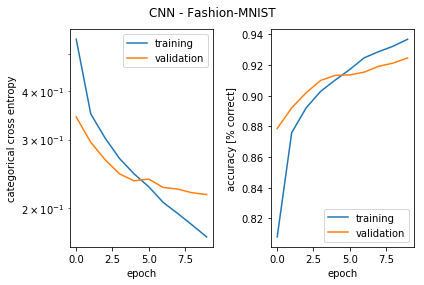

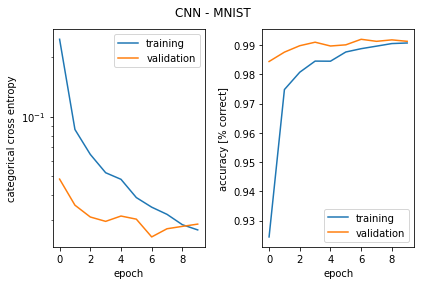

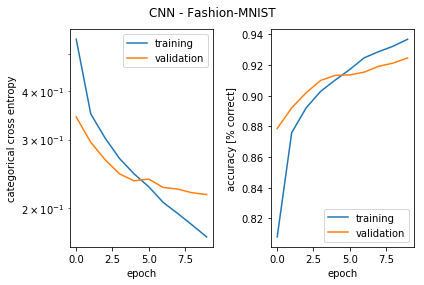

In [12]:
history_adam = make_conv(10, input_shape, x_train, y_train, x_test, y_test, 10, 'relu',0)
history_adam_fashion = make_conv(10, input_shape, x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test, 10, 'relu',0)

plot_history(history_adam, 'CNN - MNIST')
plot_history(history_adam_fashion, 'CNN - Fashion-MNIST')

Answer to question 3: The CNN performance is much better for both datasets but it takes much more time to do the computation. For the MNIST data-set, it reaches an accuracy of more than 99.2% after 7 epochs, while only 97.6% was achieved after 100 epochs for the multi-layer model with no convolutional layers and it reaches 92.5% of accuracy for the Fashion-MNIST dataset after 10 epochs, while only 88.0% was achieved after 100 epochs for the multi-layer with no convolutional layers.

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 84s 1ms/step - loss: 1.7798 - acc: 0.3755 - val_loss: 0.3799 - val_acc: 0.9017
Epoch 2/20
60000/60000 [==============================] - 85s 1ms/step - loss: 0.4107 - acc: 0.8849 - val_loss: 0.2441 - val_acc: 0.9322
Epoch 3/20
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3157 - acc: 0.9099 - val_loss: 0.1863 - val_acc: 0.9457
Epoch 4/20
60000/60000 [==============================] - 84s 1ms/step - loss: 0.2630 - acc: 0.9246 - val_loss: 0.1537 - val_acc: 0.9560
Epoch 5/20
60000/60000 [==============================] - 90s 2ms/step - loss: 0.2193 - acc: 0.9383 - val_loss: 0.1212 - val_acc: 0.9629
Epoch 6/20
60000/60000 [==============================] - 93s 2ms/step - loss: 0.1786 - acc: 0.9485 - val_loss: 0.0956 - val_acc: 0.9707
Epoch 7/20
60000/60000 [==============================] - 104s 2ms/step - loss: 0.1446 - acc: 0.9582 - val_loss: 0.0785 - val_ac

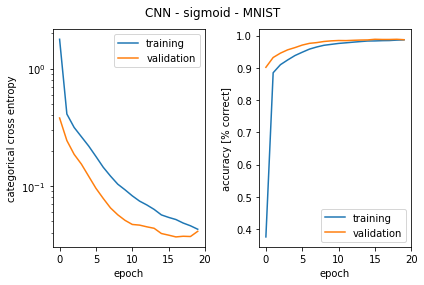

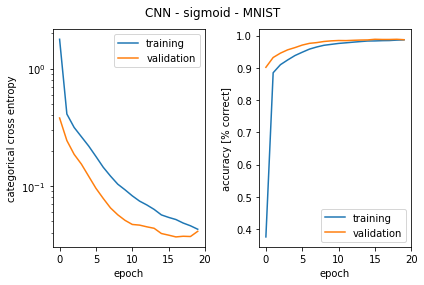

In [24]:
history_adam_sigmoid = make_conv(10, input_shape, x_train, y_train, x_test, y_test, 20, 'sigmoid',0)
plot_history(history_adam_sigmoid, 'CNN - sigmoid - MNIST')

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 120s 2ms/step - loss: 0.3315 - acc: 0.9004 - val_loss: 0.2239 - val_acc: 0.9298
Epoch 2/20
60000/60000 [==============================] - 118s 2ms/step - loss: 0.1223 - acc: 0.9644 - val_loss: 0.0529 - val_acc: 0.9828
Epoch 3/20
60000/60000 [==============================] - 120s 2ms/step - loss: 0.0926 - acc: 0.9731 - val_loss: 0.0444 - val_acc: 0.9851
Epoch 4/20
60000/60000 [==============================] - 119s 2ms/step - loss: 0.0795 - acc: 0.9764 - val_loss: 0.0428 - val_acc: 0.9860
Epoch 5/20
60000/60000 [==============================] - 120s 2ms/step - loss: 0.0705 - acc: 0.9786 - val_loss: 0.0391 - val_acc: 0.9868
Epoch 6/20
60000/60000 [==============================] - 184s 3ms/step - loss: 0.0647 - acc: 0.9802 - val_loss: 0.0372 - val_acc: 0.9882
Epoch 7/20
60000/60000 [==============================] - 118s 2ms/step - loss: 0.0624 - acc: 0.9809 - val_loss: 0.0359 - 

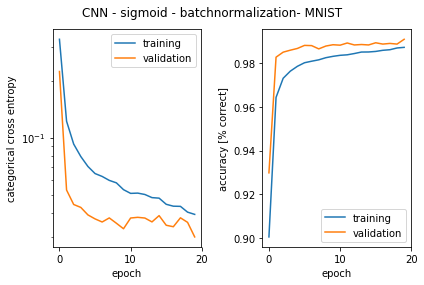

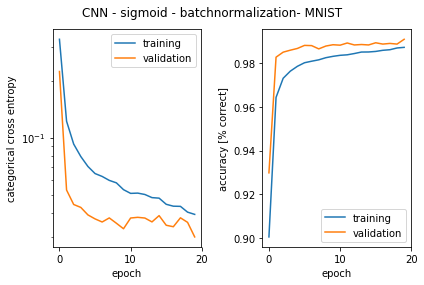

In [25]:
history_adam_sigmoid_batch = make_conv(10, input_shape, x_train, y_train, x_test, y_test, 20, 'sigmoid',1)
plot_history(history_adam_sigmoid_batch, 'CNN - sigmoid - batchnormalization- MNIST')

Answer to question 1: After training for 15 epochs, we reach a plateau of 98.7% of accuracy and don't observe a real improvement compare to the Relu-CNN.

Answer to question 2: We do observe an improvement compare to only sigmoid and in fact, after 20 epochs, the accuracy reaches 99.1% which is very close to the relu-CNN performance of the previous exercice.